In [396]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [397]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
)


In [398]:
# x normalization
x = np.concatenate((x_train, x_test),axis=0)
x_max = np.max(np.abs(x),axis=0)
x_train = x_train/x_max
x_test = x_test/x_max

# y normalization
y = np.concatenate((y_train, y_test),axis=0)
y_max = np.max(np.abs(y),axis=0)
y_train = y_train/y_max
y_test = y_test/y_max

In [399]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

# Models Training

In [400]:
from tensorflow.keras.layers import Dense

def simple_model():
	NUM_FEATURES = 13
	NUM_NEURONS = 128
	NUM_OUTPUTS = 1

	input = keras.Input(shape=(NUM_FEATURES))
	hidden = Dense(NUM_NEURONS, activation='relu')(input) 
	hidden = Dense(NUM_NEURONS/(2**1), activation='relu')(hidden) 
	hidden = Dense(NUM_NEURONS/(2**2), activation='relu')(hidden) 
	hidden = Dense(NUM_NEURONS/(2**3), activation='relu')(hidden) 
	outputs = tf.keras.layers.Dense(NUM_OUTPUTS, activation='linear')(hidden)
	model = tf.keras.Model(inputs=input, outputs=outputs)
 
	return model

In [401]:
from keras.optimizers import Adam

NUM_MODELS = 5

models = [simple_model() for i in range(NUM_MODELS)]
history = []

for model in models:
	optimizer = Adam()
	model.compile(loss='MAE',optimizer=optimizer)
	history.append(model.fit(x=x_train, y=y_train, epochs=10))
 

Epoch 1/10
11/11 [==============================] - 0s 3ms/step - loss: 0.3752
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 0.1564
Epoch 3/10
11/11 [==============================] - 0s 3ms/step - loss: 0.1211
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.1028
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0988
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0925
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0885
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0857
Epoch 9/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0807
Epoch 10/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 1/10
11/11 [==============================] - 1s 3ms/step - loss: 0.2176
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.1243
Epoch 3/10
11/11 [==============================] -

In [402]:
predictions = [model.predict(x_val) for model in models]
predictions = np.array(predictions).reshape((len(x_val),NUM_MODELS))

2/2 [==============================] - 0s 3ms/step


# Weights training

In [403]:
input = keras.Input(shape=(NUM_MODELS))
hidden = Dense(NUM_MODELS**2, activation='relu')(input)
outputs = tf.keras.layers.Dense(1, activation='linear')(hidden)
wlmodel = tf.keras.Model(inputs=input, outputs=outputs)

optimizer = Adam()
wlmodel.compile(loss='MAE',optimizer=optimizer,metrics=["MSE"])
history = wlmodel.fit(x=predictions, y=y_val, validation_split=0.1, epochs=20)


Epoch 1/20
2/2 [==============================] - 0s 95ms/step - loss: 0.4683 - MSE: 0.2406 - val_loss: 0.5116 - val_MSE: 0.2874
Epoch 2/20
2/2 [==============================] - 0s 26ms/step - loss: 0.4562 - MSE: 0.2292 - val_loss: 0.4978 - val_MSE: 0.2737
Epoch 3/20
2/2 [==============================] - 0s 25ms/step - loss: 0.4443 - MSE: 0.2184 - val_loss: 0.4839 - val_MSE: 0.2604
Epoch 4/20
2/2 [==============================] - 0s 24ms/step - loss: 0.4323 - MSE: 0.2081 - val_loss: 0.4702 - val_MSE: 0.2476
Epoch 5/20
2/2 [==============================] - 0s 28ms/step - loss: 0.4197 - MSE: 0.1975 - val_loss: 0.4563 - val_MSE: 0.2350
Epoch 6/20
2/2 [==============================] - 0s 24ms/step - loss: 0.4071 - MSE: 0.1868 - val_loss: 0.4422 - val_MSE: 0.2227
Epoch 7/20
2/2 [==============================] - 0s 24ms/step - loss: 0.3942 - MSE: 0.1767 - val_loss: 0.4284 - val_MSE: 0.2109
Epoch 8/20
2/2 [==============================] - 0s 24ms/step - loss: 0.3809 - MSE: 0.1664 - val

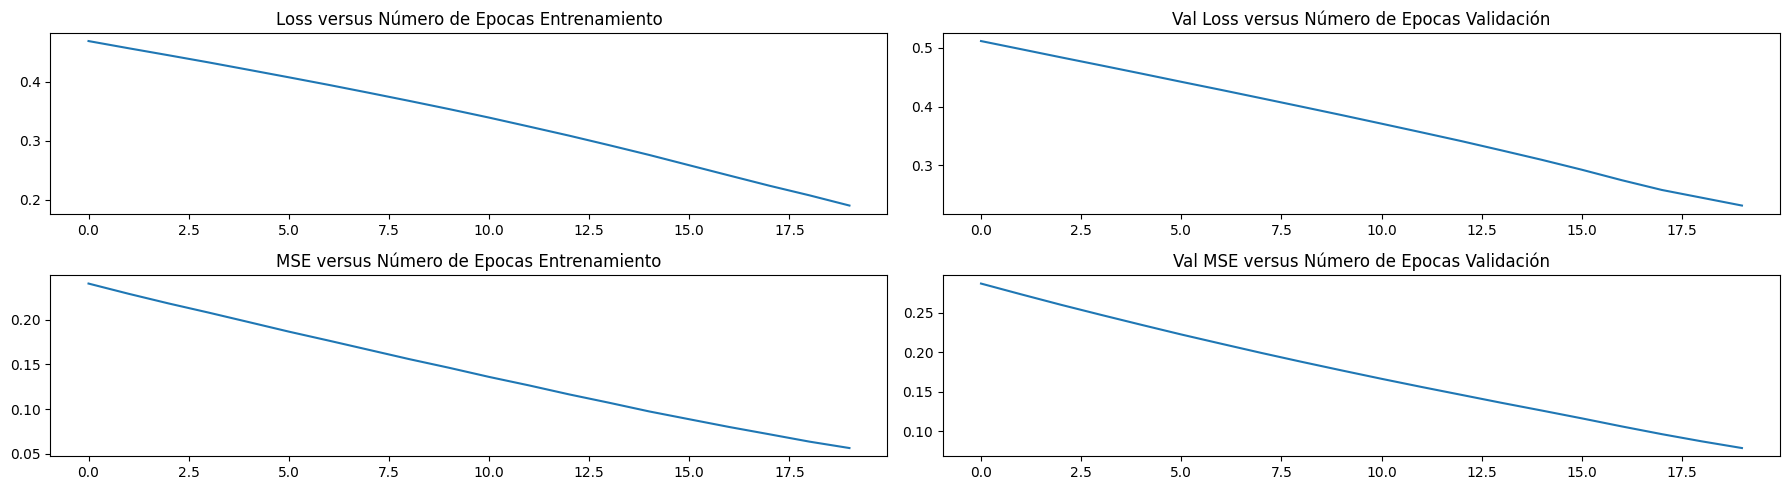

In [404]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2, 2, figsize=(18,5))
axis[0,0].plot(history.history['loss'], label='train loss')
axis[0,1].plot(history.history['val_loss'], label='val loss')
axis[1,0].plot(history.history['MSE'], label='train mse')
axis[1,1].plot(history.history['val_MSE'], label='val mse')
axis[0,0].set_title("Loss versus Número de Epocas Entrenamiento")
axis[0,1].set_title("Val Loss versus Número de Epocas Validación")
axis[1,0].set_title("MSE versus Número de Epocas Entrenamiento")
axis[1,1].set_title("Val MSE versus Número de Epocas Validación")
plt.tight_layout()
plt.show()

In [405]:
ensemble_prediction = wlmodel.predict(predictions)
ensemble_prediction = ensemble_prediction.T[0]

2/2 [==============================] - 0s 2ms/step


In [406]:
uncertainty = np.std((y_val - ensemble_prediction)*y_max)
uncertainty


7.633406347702166

In [407]:
# #0 = expected value, #1 = prediction
in_range = lambda y, yhat: 1 if (y >= (yhat-uncertainty) and y <= (yhat+uncertainty)) else 0
l = [in_range(y,yhat) for y,yhat in zip(ensemble_prediction,y_val)]
d = {'value':y_val*y_max,'prediction':ensemble_prediction.T[0]*y_max,'in_range':np.array(l).T}
df = pd.DataFrame(d)

In [408]:
df

,value,prediction,in_range
0,19.3,11.837938,1
1,23.3,11.837938,1
2,17.5,11.837938,1
3,23.1,11.837938,1
4,22.2,11.837938,1
...,...,...,...
56,17.8,11.837938,1
57,36.4,11.837938,1
58,20.0,11.837938,1
59,36.5,11.837938,1


In [409]:
aux = np.array(predictions).reshape((NUM_MODELS,61))
for i in range(NUM_MODELS):
  df["model_"+str(i)] = aux[i]*y_max

In [410]:
df

,value,prediction,in_range,model_0,model_1,model_2,model_3,model_4
0,19.3,11.837938,1,21.524031,20.097237,20.137669,20.963306,20.347898
1,23.3,11.837938,1,22.265568,26.655787,26.350414,27.890032,24.944540
2,17.5,11.837938,1,20.256870,17.856976,17.941456,18.421118,19.289366
3,23.1,11.837938,1,22.626137,21.496300,22.523615,23.010525,21.762461
4,22.2,11.837938,1,23.921658,23.123518,24.191263,23.695349,22.591499
...,...,...,...,...,...,...,...,...
56,17.8,11.837938,1,17.877966,15.506927,15.481528,16.855366,17.656591
57,36.4,11.837938,1,27.497015,29.949982,30.688499,32.029778,29.780811
58,20.0,11.837938,1,19.365910,17.963768,17.569178,19.913921,20.214453
59,36.5,11.837938,1,26.613045,33.231007,36.601643,32.235825,30.703268


<BarContainer object of 2 artists>

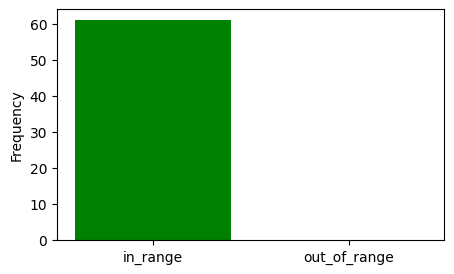

In [411]:
# TODO: bar plot con cantidad de valores in range
num_in_range = len(df[df['in_range'] == 1])
num_out_range = len(df['in_range']) - num_in_range

x_data = ['in_range', 'out_of_range']
h = [num_in_range, num_out_range]


fig = plt.figure(figsize =(5, 3))
plt.ylabel('Frequency')
plt.bar(x_data, h, color ='green')

In [412]:
predictions = [model.predict(x_val) for model in models]

2/2 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Diferencia entre predicción por modelo y valor esperado')

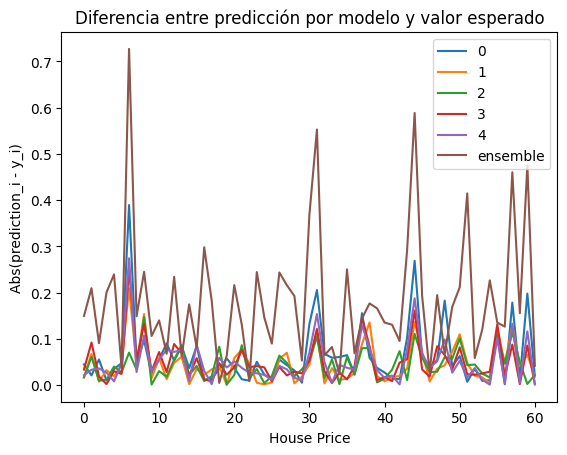

In [413]:
#TODO: algo que me permita saber la precision de los predictores en las distintas zonas de la prediccion
from scipy import interpolate

predictions_diff = abs(np.array(predictions).reshape((NUM_MODELS,len(y_val))) - y_val.T)

for predictor in predictions_diff:
	plt.plot(predictor)
 	
plt.plot(abs(ensemble_prediction - y_val))
 
plt.legend([str(i) for i in range(NUM_MODELS)]+["ensemble"])

plt.xlabel("House Price")
plt.ylabel("Abs(prediction_i - y_i)")
plt.title("Diferencia entre predicción por modelo y valor esperado")